In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Reshape, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError

# for SNGP
import gpflow
import gpflux
from gpflow.config import default_float
from lib.spectral_normalization import SpectralNormalization

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae

plt.rcParams.update({'font.size': 18})

## Load the Capacity data
- Three datasets: Train, Test1, Test2, Test3

In [3]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

all_Q_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_Q = pd.read_csv("Dataset/discharge_capacity/"+dataset[myset]+"/cell"+str(cell+1)+".csv", 
                               header = None, names=['cycle_no', 'capacity', 'initial_capacity'])
        cell_Q['cell_no'] = cell+1 # cell number
        cell_Q['norm_Q'] = cell_Q['capacity']/cell_Q['initial_capacity'].iloc[0] # cell number
        cell_Q['dataset'] = dataset[myset]
        all_Q_curves = pd.concat([all_Q_curves, cell_Q], axis=0)

## Load the VQ curve data

### We will use VQ(cycle=100)-VQ(cycle=10) as feature to determine RUL

In [4]:
VQcol_names = ["cycle_"+str(i+1) for i in range(150)]
all_VQ_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_VQ = pd.read_csv("Dataset/V_Q_curve/"+dataset[myset]+"/cell"+str(cell+1)+".csv", header = None,
                               names=VQcol_names)
        cell_VQ['voltage'] = np.linspace(3.5,2,cell_VQ.shape[0])
        cell_VQ['diff_cycle100_cycle10'] = cell_VQ['cycle_100']-cell_VQ['cycle_10']
        cell_VQ['cell_no'] = cell+1 # cell number
        cell_VQ['dataset'] = dataset[myset]
        all_VQ_curves = pd.concat([all_VQ_curves, cell_VQ], axis=0)

In [5]:
all_cycle_lives = pd.DataFrame()
for myset in range(len(dataset)):
    cycle_lives = pd.read_csv("Dataset/cycle_lives/"+dataset[myset]+"_cycle_lives.csv", header = None,
                             names=['cycle_life']).reset_index()
    cycle_lives['cell_no'] = cycle_lives['index'] + 1
    cycle_lives['dataset'] = dataset[myset]
    
    all_cycle_lives = pd.concat([all_cycle_lives, cycle_lives.drop('index', axis=1)], axis=0)

In [6]:
all_VQ_curves_merge = pd.merge(all_VQ_curves, all_cycle_lives, how='left',
                               left_on = ['dataset', 'cell_no'], right_on = ['dataset', 'cell_no'])
all_VQ_curves_merge_agg = all_VQ_curves_merge.groupby(by=['cell_no', 'dataset']).agg({'diff_cycle100_cycle10':'var',
                                                            'cycle_life': 'mean'}).reset_index()

## Make Input-Output for training the UQ models
Input:- VQ(100)-VQ(10)

Output:- cycle life

In [7]:
def get_input_output(df, myset):
    df_myset = df.loc[df['dataset']==myset]
    X, Y = [], []
    for mycell in sorted(set(df_myset['cell_no'])):
        X.append(df_myset.loc[df_myset['cell_no']==mycell].sort_values(
            by='voltage', ascending = False, axis = 0)['diff_cycle100_cycle10'].values)
        Y.append(df_myset.loc[df_myset['cell_no']==mycell]['cycle_life'].mean())
    return X, np.expand_dims(Y, axis=1)

In [8]:
Xtrain, Ytrain = get_input_output(all_VQ_curves_merge, 'train')
Xtest1, Ytest1 = get_input_output(all_VQ_curves_merge, 'test1')
Xtest2, Ytest2 = get_input_output(all_VQ_curves_merge, 'test2')
Xtest3, Ytest3 = get_input_output(all_VQ_curves_merge, 'test3')

scalerX = MinMaxScaler()
Xtrain_norm, Ytrain_norm  = scalerX.fit_transform(Xtrain), (Ytrain)/np.max(Ytrain)
Xtest1_norm, Ytest1_norm  = scalerX.transform(Xtest1), (Ytest1)/np.max(Ytrain)
Xtest2_norm, Ytest2_norm  = scalerX.transform(Xtest2), (Ytest2)/np.max(Ytrain)
Xtest3_norm, Ytest3_norm  = scalerX.transform(Xtest3), (Ytest3)/np.max(Ytrain)

## Common functions definitions

In [10]:
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    alphas = np.linspace(1e-10, 1-1e-10, 1000)
    myCI=[]
    for myalpha in sorted(alphas):
        intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        myCI.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    return 100*alphas, 100*np.array(myCI)  # converting to percentages

## SNGP

distance-aware based

 - spectral normalization from keras layers
 - gaussian process from gpflow, gpflux libraries

(inspiration from https://secondmind-labs.github.io/GPflux/notebooks/gpflux_with_keras_layers.html and https://www.tensorflow.org/tutorials/understanding/sngp)

edited source file envs/py3/lib/python3.10/site-packages/gpflux/layers/gp_layer.py
line 212 from num_inducing ->  num_inducing.numpy()

In [11]:
def generate_trained_SNGPmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    # define Gaussian layer
    num_data = len(trainX)
    num_inducing = 20
    output_dim = trainY.shape[1]

    kernel = gpflow.kernels.SquaredExponential()
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.linspace(trainX.min(), trainY.min(), num_inducing).reshape(-1, 1)
    )
    gp_layer = gpflux.layers.GPLayer(
        kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
    )

    likelihood = gpflow.likelihoods.Gaussian(0.1)

    # So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
    likelihood_container = gpflux.layers.TrackableLayer()
    likelihood_container.likelihood = likelihood

    # define model
    model = tf.keras.Sequential(
        [
            SpectralNormalization(Dense(100, activation=actfn), norm_multiplier=0.9),
            SpectralNormalization(Dense(10, activation=actfn), norm_multiplier=0.9),
            SpectralNormalization(Dense(1, activation=actfn), norm_multiplier=0.9),
            gp_layer,
            likelihood_container,  # no-op, for discovering trainable likelihood parameters
        ]
    )
    loss = gpflux.losses.LikelihoodLoss(likelihood)
    model.compile(loss=loss, optimizer="adam")
    hist= model.fit(trainX, trainY, epochs=nepochs, verbose=0)
#     plt.plot(hist.history["loss"])
    return model


In [21]:
# Single run through
nmodels = 1 # train models and select the best out of these
all_models_SNGP=[]
all_mae_train_SNGP = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, 1000, 'sigmoid')
    f_distribution = model_SNGP(Xtrain_norm)
    mean = f_distribution.mean().numpy()*(np.max(Ytrain))
    all_mae_train_SNGP[i] = mae(mean, Ytrain)
    all_models_SNGP.append(model_SNGP)

100% |#########################################################################|


In [22]:
select_modelSNGP = all_models_SNGP[np.argmin(all_mae_train_SNGP)]
print("Train MAE: ", mae(model_SNGP(Xtrain_norm).mean().numpy()*(np.max(Ytrain)), Ytrain))
print("Test1 MAE: ", mae(model_SNGP(Xtest1_norm).mean().numpy()*(np.max(Ytrain)), Ytest1))
print("Test2 MAE: ", mae(model_SNGP(Xtest2_norm).mean().numpy()*(np.max(Ytrain)), Ytest2))
print("Test3 MAE: ", mae(model_SNGP(Xtest3_norm).mean().numpy()*(np.max(Ytrain)), Ytest3))

Train MAE:  186.85253111053763
Test1 MAE:  227.9769322099894
Test2 MAE:  350.039661187169
Test3 MAE:  152.39622010201785


In [23]:
# single run
allresults_SNGPdf = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    result_df["SNGP_mu_eff"] = model_SNGP(Xnorm).mean().numpy()
    result_df["SNGP_sigma_eff"] = np.sqrt(model_SNGP(Xnorm).variance().numpy() + 
                                   model_SNGP.layers[-1].likelihood.variance.numpy())

    allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)

allresults_SNGPdf["SNGP_mu_eff"] = allresults_SNGPdf["SNGP_mu_eff"]*(np.max(Ytrain))
allresults_SNGPdf["SNGP_sigma_eff"] = allresults_SNGPdf["SNGP_sigma_eff"]*(np.max(Ytrain))

In [24]:
allresults_SNGPdf

,True,dataset,SNGP_mu_eff,SNGP_sigma_eff
0,2160.0,train,732.530100,492.422797
1,1434.0,train,700.439790,487.050402
2,1074.0,train,683.445777,485.784283
3,870.0,train,666.458721,485.660651
4,788.0,train,711.255151,488.434752
...,...,...,...,...
40,872.0,test3,676.229961,485.590416
41,837.0,test3,668.760949,485.609386
42,775.0,test3,704.327588,487.496988
43,751.0,test3,669.906171,485.591878


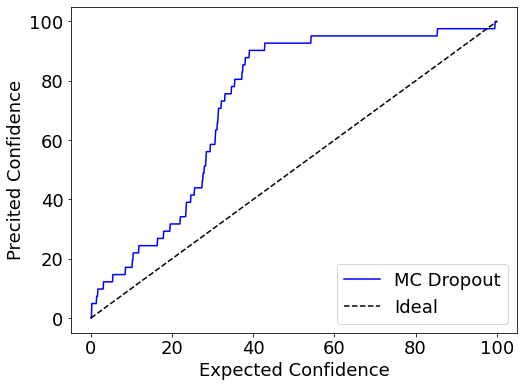

In [17]:
# plot the calibration curve
allresults_SNGPdf_train = allresults_SNGPdf.loc[allresults_SNGPdf['dataset']=='train']

alphas, CI_DE = get_confidence_interval(allresults_SNGPdf_train['True'].values, 
                                       allresults_SNGPdf_train['SNGP_mu_eff'].values, 
                                       allresults_SNGPdf_train['SNGP_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

In [33]:
model_train_bool = True
if model_train_bool:
    nmodels = 3 # total models trained and best one picked
    niter = 10

    allCI_SNGP = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_SNGPdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_SNGP=[]
        all_mae_train_SNGP = np.zeros(nmodels,)
        for i in range(nmodels): # train multiple models to select the best
            model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, 1000, 'sigmoid')
            f_distribution = model_SNGP(Xtrain_norm)
            mean = f_distribution.mean().numpy()*(np.max(Ytrain))
            all_mae_train_SNGP[i] = mae(mean, Ytrain)
            all_models_SNGP.append(model_SNGP)

        select_modelSNGP = all_models_SNGP[np.argmin(all_mae_train_SNGP)] # best model

        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            result_df["SNGP_mu_eff"] = select_modelSNGP(Xnorm).mean().numpy()*(np.max(Ytrain))
            result_df["SNGP_sigma_eff"] = np.sqrt(select_modelSNGP(Xnorm).variance().numpy() + 
                                           select_modelSNGP.layers[-1].likelihood.variance.numpy())*(np.max(Ytrain))
            result_df['iteration'] = myiter
            allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)
               
    allresults_SNGPdf.to_excel("SNGP_battery_prediction_results.xlsx")  
else:
    allresults_SNGPdf=pd.read_excel("SNGP_battery_prediction_results.xlsx")  

100% |#########################################################################|
